##   PUI2018 Extra Credit Project 

## Analyzing real estate market and factors influencing "hottness" of specific markets

When buyers or real estate professionals consider a market for their investments, they need to know which areas/cities show higher growth, and which markets are “hot”. 

This study is two-fold:

- first, I analyze the national markets and price dynamics for five major US cities

- second, I concentrate on NYC, the "hot" and "cold" Zip code areas within the city and see how well can we predict the overall hotness of the NYC market with some real estate and population statistic parameters. 


Parts of code for this wotk is taken from PUI notebooks https://github.com/fedhere/PUI2018_fb55

In [111]:
#initial imports
import pylab as pl
import pandas as pd
import numpy as np

#added to use the env variable PUI
import os

#added to get data from the internet
import urllib
import requests

#geospatial imports
import geopandas as gp
import shapely
from fiona.crs import from_epsg

#for modeling
import sklearn.preprocessing as preprocessing
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import GradientBoostingClassifier as gdb
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

%pylab inline

import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

%matplotlib inline
import matplotlib.pyplot as plt

#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


Populating the interactive namespace from numpy and matplotlib


## 1. Analyzing historical price growth in major cities

In [2]:
# historical data on national level is taken from from Realtor.com Real Estate Data Library
df = pd.read_csv('https://s3-us-west-2.amazonaws.com/econresearch/Reports/Core/RDC_InventoryCoreMetrics_Zip_Hist.csv')
df.head(5)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Month,ZipCode,ZipName,Footnote,Median Listing Price,Median Listing Price M/M,Median Listing Price Y/Y,Active Listing Count,Active Listing Count M/M,Active Listing Count Y/Y,...,Pending Listing Count Y/Y,Avg Listing Price,Avg Listing Price M/M,Avg Listing Price Y/Y,Total Listing Count,Total Listing Count M/M,Total Listing Count Y/Y,Pending Ratio,Pending Ratio M/M,Pending Ratio Y/Y
0,2018-11-01 00:00:00,1001.0,"Agawam, MA",NaN,205050.0,-0.0885,-0.0485,73.0,0.0210,0.3905,...,0.0,248403.0,-0.0318,0.0051,74.0,0.0207,0.3832,0.0137,-0.0003,-0.0053
1,2018-11-01 00:00:00,1002.0,"Amherst, MA",NaN,435222.0,0.0205,0.1187,79.0,-0.0595,-0.1366,...,NaN,469807.0,0.0094,-0.0037,79.0,-0.0595,-0.1366,0.0000,0.0000,0.0000
2,2018-11-01 00:00:00,1005.0,"Barre, MA",*,241550.0,-0.0488,NaN,35.0,-0.0411,NaN,...,NaN,313830.0,-0.0545,0.3020,35.0,-0.0411,0.4286,0.0000,0.0000,0.0000
3,2018-11-01 00:00:00,1007.0,"Belchertown, MA",NaN,325000.0,0.0491,0.0158,54.5,-0.0522,-0.2968,...,NaN,345311.0,0.0008,0.0317,54.5,-0.0522,-0.2968,0.0000,0.0000,0.0000
4,2018-11-01 00:00:00,1008.0,"Blandford, MA",*,246500.0,-0.0474,NaN,12.0,-0.2000,NaN,...,0.0,255552.0,-0.0437,-0.0693,14.0,-0.1765,0.2174,0.1667,0.0333,-0.0439


In [3]:
df.columns

Index(['Month', 'ZipCode', 'ZipName', 'Footnote', 'Median Listing Price',
       'Median Listing Price M/M', 'Median Listing Price Y/Y',
       'Active Listing Count ', 'Active Listing Count M/M',
       'Active Listing Count Y/Y', 'Days on Market ', 'Days on Market M/M',
       'Days on Market Y/Y', 'New Listing Count ', 'New Listing Count M/M',
       'New Listing Count Y/Y', 'Price Increase Count ',
       'Price Increase Count M/M', 'Price Increase Count Y/Y',
       'Price Decrease Count ', 'Price Decrease Count M/M',
       'Price Decrease Count Y/Y', 'Pending Listing Count ',
       'Pending Listing Count M/M', 'Pending Listing Count Y/Y',
       'Avg Listing Price', 'Avg Listing Price M/M', 'Avg Listing Price Y/Y',
       'Total Listing Count', 'Total Listing Count M/M',
       'Total Listing Count Y/Y', 'Pending Ratio', 'Pending Ratio M/M',
       'Pending Ratio Y/Y'],
      dtype='object')

In [4]:
#droping columns that are not interesting for the purposes of my analysis
df.drop(['Month', "Median Listing Price M/M", "Median Listing Price Y/Y", "Active Listing Count M/M", 
         "Active Listing Count Y/Y", "Days on Market M/M", "Active Listing Count Y/Y", "Days on Market M/M",
         "Days on Market Y/Y", "New Listing Count M/M", "New Listing Count Y/Y", "Price Increase Count M/M",
         "Price Increase Count Y/Y", "Price Decrease Count M/M", "Price Decrease Count Y/Y", "Avg Listing Price M/M",
         "Total Listing Count Y/Y", 'Pending Ratio', "Pending Ratio M/M", "Pending Ratio Y/Y", 'Pending Listing Count ', "Pending Listing Count M/M", 
         "Pending Listing Count Y/Y", "Avg Listing Price Y/Y", "Total Listing Count M/M", 
         "Footnote"], axis = 1, inplace = True)
df.drop(1184264, axis = 0, inplace = True)  

df.tail(5)

,Month,ZipCode,ZipName,Median Listing Price,Active Listing Count,Days on Market,New Listing Count,Price Increase Count,Price Decrease Count,Avg Listing Price,Total Listing Count
1184259,2012-05-01 00:00:00,99737.0,"Delta Junction, AK",225050.0,53.0,293.50,8.0,0.0,6.0,218114.0,53.0
1184260,2012-05-01 00:00:00,99801.0,"Juneau, AK",323900.0,82.0,49.75,42.0,2.0,18.0,369411.0,82.0
1184261,2012-05-01 00:00:00,99833.0,"Petersburg, AK",211550.0,19.5,224.75,6.0,0.0,2.0,274947.0,19.5
1184262,2012-05-01 00:00:00,99835.0,"Sitka, AK",497550.0,25.0,346.25,10.0,0.0,2.0,693370.0,25.0
1184263,2012-05-01 00:00:00,99901.0,"Ketchikan, AK",253800.0,77.5,163.50,10.0,0.0,8.0,284063.0,77.5


In [ ]:
df['Date'] = pd.to_datetime(df.Month)

In [7]:
df["ZipCode"] = df["ZipCode"].apply(lambda x: int(x))
df["State"] = df["ZipName"].apply(lambda x: x.split(", ")[1])
df["ZipName"] = df["ZipName"].apply(lambda x: x.split(", ")[0])

df.head(5)

,Month,ZipCode,ZipName,Median Listing Price,Active Listing Count,Days on Market,New Listing Count,Price Increase Count,Price Decrease Count,Avg Listing Price,Total Listing Count,Date,State
0,2018-11-01 00:00:00,1001,Agawam,205050.0,73.0,62.75,22.0,0.0,22.0,248403.0,74.0,2018-11-01,MA
1,2018-11-01 00:00:00,1002,Amherst,435222.0,79.0,111.50,8.0,0.0,6.0,469807.0,79.0,2018-11-01,MA
2,2018-11-01 00:00:00,1005,Barre,241550.0,35.0,64.75,6.0,0.0,8.0,313830.0,35.0,2018-11-01,MA
3,2018-11-01 00:00:00,1007,Belchertown,325000.0,54.5,83.25,12.0,0.0,10.0,345311.0,54.5,2018-11-01,MA
4,2018-11-01 00:00:00,1008,Blandford,246500.0,12.0,97.75,0.0,0.0,6.0,255552.0,14.0,2018-11-01,MA


Text(0,0.5,'Average Listing Price')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


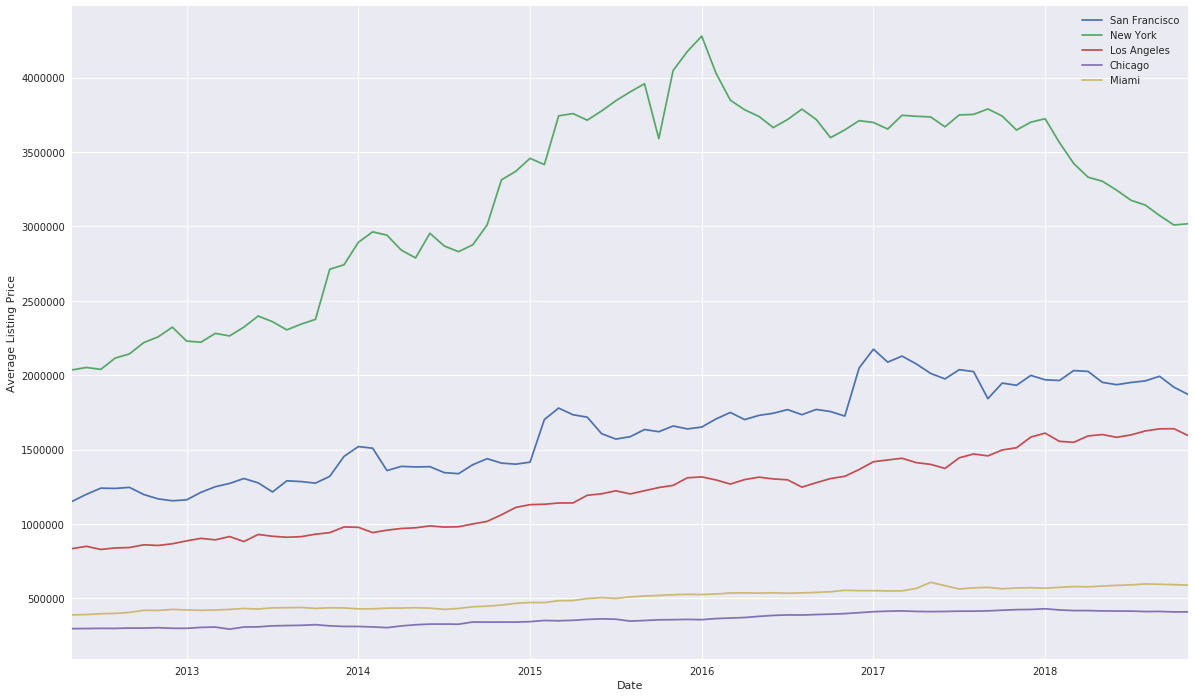

In [8]:
#plotting five major cities

plt.figure(figsize = (20,12))

df[df["ZipName"] == "San Francisco"].groupby("Date")["Avg Listing Price"].mean().plot(label = "San Francisco")
df[df["ZipName"] == "New York"].groupby("Date")["Avg Listing Price"].mean().plot(label = "New York")
df[df["ZipName"] == "Los Angeles"].groupby("Date")["Avg Listing Price"].mean().plot(label = "Los Angeles")
df[df["ZipName"] == "Chicago"].groupby("Date")["Avg Listing Price"].mean().plot(label = "Chicago")
df[df["ZipName"] == "Miami"].groupby("Date")["Avg Listing Price"].mean().plot(label = "Miami")

plt.legend(loc = 0)
plt.title('Average listing price dynamics for 2013-2018')

plt.ylabel("Average Listing Price")

#### Fig 1. Historical dynamics of Average Listing Price for five major US cities for 2013-2018.


It is clear that New York and San Francisco are leaders in both average listing price and variation of the price. New York prices show sharp decline in 2018. Chicago and Miami markets have more stability. 


## 2. Analyzing the "hotness index" of NYC 

In [64]:
#again, data is taken from from Realtor.com Real Estate Data Library

#this time, data is for November 2018 only, data includes 
#Realtor.com Market Hotness Index: scores and rankings based on supply index and demand index (based on internal data).

ind = pd.read_csv("https://s3-us-west-2.amazonaws.com/econresearch/Reports/Hotness/RDC_MarketHotness_Monthly_Zip.csv")
ind.head()

,Month,ZipCode,ZipName,Nielsen HH Rank,Hotness Rank Within County,CountyFIPS,CountyName,Hotness Rank Within CBSA,CBSACode,CBSATitle,...,Views Per Property (vs US),Views Per Property (vs CBSA),Views Per Property (vs County),Median Listing Price,Median Listing Price M/M,Median Listing Price Y/Y,Median Listing Price (vs US),Median Listing Price (vs CBSA),Median Listing Price (vs County),Quality Flag
0,201811,1701,"Framingham, MA",2811,23.0,25017,Middlesex,47.0,14460,"Boston-Cambridge-Newton, MA-NH",...,2.0968,0.9962,0.8609,499225.0,0.0005,-0.0014,1.7038,0.9972,0.8462,NaN
1,201811,1519,"Grafton, MA",11750,35.0,25027,Worcester,36.0,49340,"Worcester, MA-CT",...,1.6532,0.9670,0.9152,429225.0,-0.0130,-0.0564,1.4649,1.4312,1.3417,NaN
2,201811,1850,"Lowell, MA",7793,10.0,25017,Middlesex,17.0,14460,"Boston-Cambridge-Newton, MA-NH",...,4.8790,2.3180,2.0033,255000.0,-0.0329,0.0619,0.8703,0.5094,0.4322,NaN
3,201811,1583,"West Boylston, MA",11474,17.0,25027,Worcester,17.0,49340,"Worcester, MA-CT",...,1.5887,0.9292,0.8795,324900.0,-0.0189,0.0656,1.1089,1.0834,1.0156,NaN
4,201811,1944,"Manchester, MA",12371,38.0,25009,Essex,239.0,14460,"Boston-Cambridge-Newton, MA-NH",...,1.4839,0.7050,0.5125,1600000.0,0.0670,-0.1049,5.4608,3.1960,3.3688,NaN


In [65]:
ind.columns

Index(['Month', 'ZipCode', 'ZipName', 'Nielsen HH Rank',
       'Hotness Rank Within County', 'CountyFIPS', 'CountyName',
       'Hotness Rank Within CBSA', 'CBSACode', 'CBSATitle', 'Hotness Rank ',
       'Hotness Rank M/M', 'Hotness Rank Y/Y', 'Hotness Score', 'Supply Score',
       'Demand Score', 'Median DOM', 'Median DOM M/M', 'Median DOM M/M Perc',
       'Median DOM Y/Y', 'Median DOM Y/Y Perc', 'Median DOM (vs US)',
       'Median DOM (vs CBSA)', 'Median DOM (vs County)',
       'Views Per Property M/M', 'Views Per Property Y/Y',
       'Views Per Property  (vs US)', 'Views Per Property  (vs CBSA)',
       'Views Per Property  (vs County)', 'Median Listing Price',
       'Median Listing Price M/M', 'Median Listing Price Y/Y',
       'Median Listing Price  (vs US)', 'Median Listing Price  (vs CBSA)',
       'Median Listing Price  (vs County)', 'Quality Flag'],
      dtype='object')

In [66]:
#checking for values 
indNY = ind[ind['ZipName'].str.contains('NY')]
indNY['ZipName'].value_counts()

New York, NY            43
Brooklyn, NY            37
Buffalo, NY             23
Rochester, NY           18
Bronx, NY               17
Syracuse, NY            13
Staten Island, NY       12
Albany, NY               8
Schenectady, NY          6
White Plains, NY         5
Jamaica, NY              5
Yonkers, NY              5
Astoria, NY              4
Great Neck, NY           4
Niagara Falls, NY        4
Elmira, NY               4
Flushing, NY             4
Binghamton, NY           4
Mount Vernon, NY         3
Queens Village, NY       3
New Rochelle, NY         3
Middletown, NY           2
Floral Park, NY          2
Troy, NY                 2
Valley Stream, NY        2
Little Neck, NY          2
Long Island City, NY     2
Utica, NY                2
Liverpool, NY            2
Bayside, NY              2
                        ..
Preston Hollow, NY       1
Orangeburg, NY           1
Tuckahoe, NY             1
Parksville, NY           1
Rensselaer, NY           1
Elka Park, NY            1
S

In [67]:
#taking only NY
indMan = ind[ind['ZipName'].str.contains('New York, NY')]
indMan['ZipName'].value_counts()

In [68]:
indMan['ZipName'].value_counts()

New York, NY    43
Name: ZipName, dtype: int64

In [69]:
#43 areas (zip codes) were analyzed, this is the index that I need (although there are a lot of other hotness indexes)
indMan['Hotness Rank Within County'].value_counts()

43.0    1
11.0    1
19.0    1
18.0    1
17.0    1
16.0    1
15.0    1
14.0    1
13.0    1
12.0    1
10.0    1
21.0    1
9.0     1
8.0     1
7.0     1
6.0     1
5.0     1
4.0     1
3.0     1
2.0     1
20.0    1
22.0    1
42.0    1
33.0    1
41.0    1
40.0    1
39.0    1
38.0    1
37.0    1
36.0    1
35.0    1
34.0    1
32.0    1
23.0    1
31.0    1
30.0    1
29.0    1
28.0    1
27.0    1
26.0    1
25.0    1
24.0    1
1.0     1
Name: Hotness Rank Within County, dtype: int64

In [70]:
#taking only NYC
indMan['CountyName'].value_counts()

New York    43
Name: CountyName, dtype: int64

In [71]:
indMan.drop(['Month', 'ZipName', 'Nielsen HH Rank',
        'CountyFIPS', 'CountyName',
       'Hotness Rank Within CBSA', 'CBSACode', 'CBSATitle', 'Hotness Rank ',
       'Hotness Rank M/M', 'Hotness Rank Y/Y', 'Hotness Score', 'Supply Score',
       'Demand Score', 'Median DOM M/M', 'Median DOM M/M Perc',
       'Median DOM Y/Y', 'Median DOM Y/Y Perc', 'Median DOM (vs US)',
       'Median DOM (vs CBSA)', 'Median DOM (vs County)',
       'Views Per Property M/M', 'Views Per Property Y/Y',
       'Views Per Property  (vs US)', 'Views Per Property  (vs CBSA)',
       'Median Listing Price M/M', 'Median Listing Price Y/Y',
       'Median Listing Price  (vs US)', 'Median Listing Price  (vs CBSA)',
       'Median Listing Price  (vs County)', 'Quality Flag'],axis=1, inplace=True)
indMan.tail()


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ZipCode,Hotness Rank Within County,Median DOM,Views Per Property (vs County),Median Listing Price
15017,10024,20.0,69,1.0238,2136250.0
15034,10002,28.0,80,0.6905,1559500.0
15036,10011,11.0,61,0.8571,1995000.0
15793,10044,41.0,158,1.2381,1257250.0
15795,10128,31.0,86,0.8571,1736750.0


In [72]:
#statistical data from https://opendata.cityofnewyork.us/
#zip code statistics
stat = pd.read_csv("https://data.cityofnewyork.us/api/views/kku6-nxdu/rows.csv?accessType=DOWNLOAD")

In [73]:
stat.head(10)

,JURISDICTION NAME,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,PERCENT MALE,COUNT GENDER UNKNOWN,PERCENT GENDER UNKNOWN,COUNT GENDER TOTAL,PERCENT GENDER TOTAL,...,COUNT CITIZEN STATUS TOTAL,PERCENT CITIZEN STATUS TOTAL,COUNT RECEIVES PUBLIC ASSISTANCE,PERCENT RECEIVES PUBLIC ASSISTANCE,COUNT NRECEIVES PUBLIC ASSISTANCE,PERCENT NRECEIVES PUBLIC ASSISTANCE,COUNT PUBLIC ASSISTANCE UNKNOWN,PERCENT PUBLIC ASSISTANCE UNKNOWN,COUNT PUBLIC ASSISTANCE TOTAL,PERCENT PUBLIC ASSISTANCE TOTAL
0,10001,44,22,0.50,22,0.50,0,0,44,100,...,44,100,20,0.45,24,0.55,0,0,44,100
1,10002,35,19,0.54,16,0.46,0,0,35,100,...,35,100,2,0.06,33,0.94,0,0,35,100
2,10003,1,1,1.00,0,0.00,0,0,1,100,...,1,100,0,0.00,1,1.00,0,0,1,100
3,10004,0,0,0.00,0,0.00,0,0,0,0,...,0,0,0,0.00,0,0.00,0,0,0,0
4,10005,2,2,1.00,0,0.00,0,0,2,100,...,2,100,0,0.00,2,1.00,0,0,2,100
5,10006,6,2,0.33,4,0.67,0,0,6,100,...,6,100,0,0.00,6,1.00,0,0,6,100
6,10007,1,0,0.00,1,1.00,0,0,1,100,...,1,100,1,1.00,0,0.00,0,0,1,100
7,10009,2,0,0.00,2,1.00,0,0,2,100,...,2,100,0,0.00,2,1.00,0,0,2,100
8,10010,0,0,0.00,0,0.00,0,0,0,0,...,0,0,0,0.00,0,0.00,0,0,0,0
9,10011,3,2,0.67,1,0.33,0,0,3,100,...,3,100,0,0.00,3,1.00,0,0,3,100


In [74]:
stat["JURISDICTION NAME"].dtype

dtype('int64')

In [75]:
indMan.ZipCode.dtype

dtype('int64')

In [76]:
stat.columns

Index(['JURISDICTION NAME', 'COUNT PARTICIPANTS', 'COUNT FEMALE',
       'PERCENT FEMALE', 'COUNT MALE', 'PERCENT MALE', 'COUNT GENDER UNKNOWN',
       'PERCENT GENDER UNKNOWN', 'COUNT GENDER TOTAL', 'PERCENT GENDER TOTAL',
       'COUNT PACIFIC ISLANDER', 'PERCENT PACIFIC ISLANDER',
       'COUNT HISPANIC LATINO', 'PERCENT HISPANIC LATINO',
       'COUNT AMERICAN INDIAN', 'PERCENT AMERICAN INDIAN',
       'COUNT ASIAN NON HISPANIC', 'PERCENT ASIAN NON HISPANIC',
       'COUNT WHITE NON HISPANIC', 'PERCENT WHITE NON HISPANIC',
       'COUNT BLACK NON HISPANIC', 'PERCENT BLACK NON HISPANIC',
       'COUNT OTHER ETHNICITY', 'PERCENT OTHER ETHNICITY',
       'COUNT ETHNICITY UNKNOWN', 'PERCENT ETHNICITY UNKNOWN',
       'COUNT ETHNICITY TOTAL', 'PERCENT ETHNICITY TOTAL',
       'COUNT PERMANENT RESIDENT ALIEN', 'PERCENT PERMANENT RESIDENT ALIEN',
       'COUNT US CITIZEN', 'PERCENT US CITIZEN', 'COUNT OTHER CITIZEN STATUS',
       'PERCENT OTHER CITIZEN STATUS', 'COUNT CITIZEN STATUS UNKN

In [77]:
#delete the fields that I do not need for future analysis
stat.drop(['COUNT FEMALE',
       'PERCENT FEMALE', 'COUNT MALE', 'PERCENT MALE', 'COUNT GENDER UNKNOWN',
       'PERCENT GENDER UNKNOWN', 'COUNT GENDER TOTAL', 'PERCENT GENDER TOTAL',
       'COUNT PACIFIC ISLANDER', 'PERCENT PACIFIC ISLANDER',
       'COUNT HISPANIC LATINO', 'PERCENT HISPANIC LATINO',
       'COUNT AMERICAN INDIAN', 'PERCENT AMERICAN INDIAN',
       'COUNT ASIAN NON HISPANIC', 'PERCENT ASIAN NON HISPANIC',
       'COUNT WHITE NON HISPANIC', 'PERCENT WHITE NON HISPANIC',
       'COUNT BLACK NON HISPANIC', 'PERCENT BLACK NON HISPANIC',
       'COUNT OTHER ETHNICITY', 'PERCENT OTHER ETHNICITY',
       'COUNT ETHNICITY UNKNOWN', 'PERCENT ETHNICITY UNKNOWN',
       'COUNT ETHNICITY TOTAL', 'PERCENT ETHNICITY TOTAL',
       'COUNT PERMANENT RESIDENT ALIEN', 'PERCENT PERMANENT RESIDENT ALIEN',
       'COUNT US CITIZEN', 'COUNT OTHER CITIZEN STATUS',
       'PERCENT OTHER CITIZEN STATUS', 'COUNT CITIZEN STATUS UNKNOWN',
       'PERCENT CITIZEN STATUS UNKNOWN', 'COUNT CITIZEN STATUS TOTAL',
       'PERCENT CITIZEN STATUS TOTAL', 'COUNT RECEIVES PUBLIC ASSISTANCE',
       'COUNT NRECEIVES PUBLIC ASSISTANCE',
       'PERCENT NRECEIVES PUBLIC ASSISTANCE',
       'COUNT PUBLIC ASSISTANCE UNKNOWN', 'PERCENT PUBLIC ASSISTANCE UNKNOWN',
       'COUNT PUBLIC ASSISTANCE TOTAL', 'PERCENT PUBLIC ASSISTANCE TOTAL'],axis=1, inplace=True)
stat.head()




,JURISDICTION NAME,COUNT PARTICIPANTS,PERCENT US CITIZEN,PERCENT RECEIVES PUBLIC ASSISTANCE
0,10001,44,0.95,0.45
1,10002,35,0.94,0.06
2,10003,1,1.00,0.00
3,10004,0,0.00,0.00
4,10005,2,0.50,0.00


In [78]:
#merging datasets
df3 = indMan.merge(stat, left_on="ZipCode", right_on="JURISDICTION NAME")

In [79]:
df3.head()

,ZipCode,Hotness Rank Within County,Median DOM,Views Per Property (vs County),Median Listing Price,JURISDICTION NAME,COUNT PARTICIPANTS,PERCENT US CITIZEN,PERCENT RECEIVES PUBLIC ASSISTANCE
0,10007,40.0,125,1.1667,4348750.0,10007,1,1.00,1.00
1,10032,25.0,104,1.7857,550000.0,10032,13,0.92,0.38
2,10018,42.0,135,0.9048,1990000.0,10018,3,0.67,0.00
3,10009,2.0,47,1.3333,950000.0,10009,2,1.00,0.00
4,10013,35.0,107,1.2857,4487500.0,10013,8,1.00,0.13


In [80]:
df3.columns

Index(['ZipCode', 'Hotness Rank Within County', 'Median DOM',
       'Views Per Property  (vs County)', 'Median Listing Price',
       'JURISDICTION NAME', 'COUNT PARTICIPANTS', 'PERCENT US CITIZEN',
       'PERCENT RECEIVES PUBLIC ASSISTANCE'],
      dtype='object')

In [82]:
df3.drop(['JURISDICTION NAME'],axis=1, inplace=True)
df3.rename(columns={'ZipCode': 'Zipcode', 'Hotness Rank Within County': 'Rank', 
                    'Median DOM': 'MarketDays','Views Per Property  (vs County)': 'Views', 
                    'Price Increase Count ': 'PriceIncrease', 'Price Decrease Count ': "PriceDecrease",
       'Median Listing Price': 'MedPrice', 'COUNT PARTICIPANTS': 'People',
       'PERCENT US CITIZEN': 'Citizens', 'PERCENT RECEIVES PUBLIC ASSISTANCE': 'PublicAssist'}, 
              inplace=True)
df3.head(5)

,Zipcode,Rank,MarketDays,Views,MedPrice,People,Citizens,PublicAssist
0,10007,40.0,125,1.1667,4348750.0,1,1.00,1.00
1,10032,25.0,104,1.7857,550000.0,13,0.92,0.38
2,10018,42.0,135,0.9048,1990000.0,3,0.67,0.00
3,10009,2.0,47,1.3333,950000.0,2,1.00,0.00
4,10013,35.0,107,1.2857,4487500.0,8,1.00,0.13


In [83]:
corr_matrix = df3.corr()  # check out Pearson's R
corr_matrix['Rank'].sort_values().sort_values(ascending=False)

Rank            1.000000
MarketDays      0.607162
MedPrice        0.242261
Zipcode         0.166607
PublicAssist   -0.005761
Citizens       -0.042844
People         -0.129253
Views          -0.355140
Name: Rank, dtype: float64

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


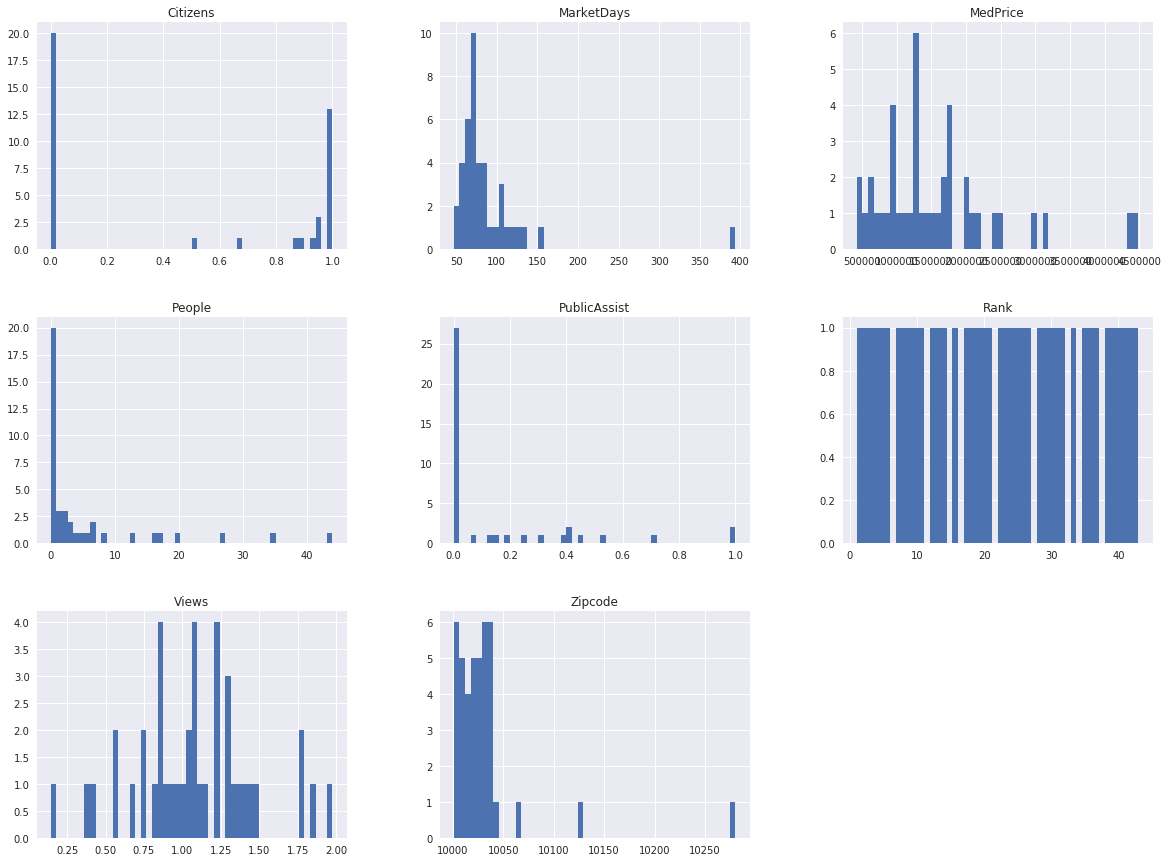

In [84]:
df3.hist(bins=50, figsize=(20,15))
plt.show()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


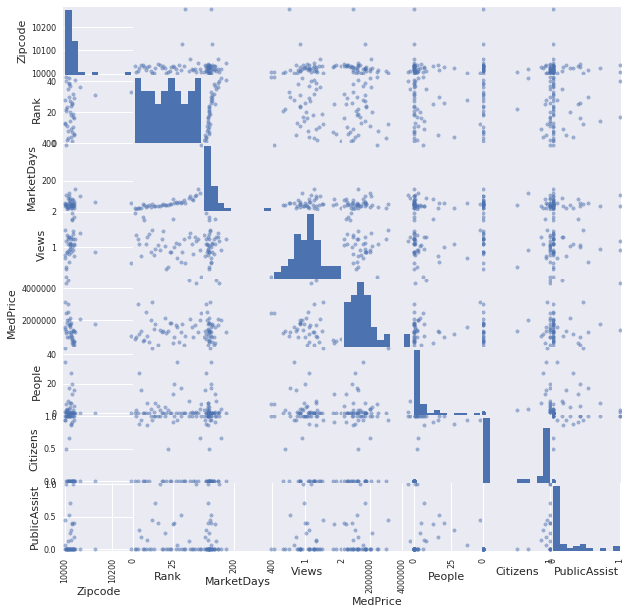

In [85]:
pd.scatter_matrix(df3, figsize=(10,10));

Fig 2: Scatter matrix of the merged dataset containing real estate and statistical variables from 2018. The variables that were plotted contain numerical data. There seem to be a correlation between the variables. 

## OLS Regression

In [90]:
rankdata = pd.DataFrame(columns=df3.columns, data=preprocessing.scale(df3))

In [91]:
rankdata.head()

,Zipcode,Rank,MarketDays,Views,MedPrice,People,Citizens,PublicAssist
0,-0.550693,1.447257,0.679128,0.226885,3.070818,-0.448967,1.091758,3.260570
1,0.009844,0.249326,0.288528,1.817263,-1.121541,0.758091,0.923874,0.896517
2,-0.304057,1.606982,0.865129,-0.446006,0.467665,-0.247790,0.399236,-0.552418
3,-0.505850,-1.587503,-0.771675,0.654926,-0.680095,-0.348378,1.091758,-0.552418
4,-0.416164,1.047947,0.344328,0.532628,3.223944,0.255150,1.091758,-0.056730


In [99]:
rankdata.columns

Index(['Zipcode', 'Rank', 'MarketDays', 'Views', 'MedPrice', 'People',
       'Citizens', 'PublicAssist'],
      dtype='object')

In [92]:
import statsmodels.formula.api as smf

In [95]:
m1 = smf.ols(formula='Rank~MarketDays+MedPrice+Views+PublicAssist+People+Citizens', data=rankdata).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     4.742
Date:                Fri, 14 Dec 2018   Prob (F-statistic):            0.00131
Time:                        21:39:22   Log-Likelihood:                -45.711
No. Observations:                  41   AIC:                             105.4
Df Residuals:                      34   BIC:                             117.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     -7.98e-17      0.127  -6.31e-16      1.000        -0.257     0.257
MarketDays       0.5427      0.139      3.904      0.000         0.260     0.825
MedPrice         0.1138      0.136      0.836      0.409        -0.163     0.390
Views           -0.2322      0.137     -1.692      0.100        -0.511     0.047
PublicAssist     0.1621      0.161      1.007      0.321        -0.165     0.489
People          -0.0495      0.151     -0.327      0.746        -0.357     0.258
Citizens        -0.2476      0.183     -1.353      0.185        -0.620     0.124
==============================================================================
Omnibus:                        1.486   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                1.146
Skew:                          -0.169   Prob(JB):                        0.564
Kurtosis:                       2.254   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
m2 = smf.ols(formula='Rank~MarketDays+MedPrice+Views+People', data=rankdata).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     6.628
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           0.000419
Time:                        21:47:22   Log-Likelihood:                -46.864
No. Observations:                  41   AIC:                             103.7
Df Residuals:                      36   BIC:                             112.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -7.98e-17      0.126  -6.31e-16      1.000        -0.257     0.257
MarketDays     0.5143      0.137      3.754      0.001         0.236     0.792
MedPrice       0.1149      0.132      0.873      0.389        -0.152     0.382
Views         -0.1899      0.133     -1.423      0.163        -0.461     0.081
People        -0.1279      0.128     -0.998      0.325        -0.388     0.132
==============================================================================
Omnibus:                        3.825   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                2.058
Skew:                          -0.279   Prob(JB):                        0.357
Kurtosis:                       2.054   Cond. No.                         1.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a relationship between the variables. The adjusted R^2 for both models indicates that 36% of the variability is accounted for by the model

In [98]:
m1.compare_lr_test(m2)

(2.3061915033650138, 0.31565805627551224, 2.0)

The likelihood of the models being compared to assess their fit. 

## Random Forest Classifier 

In [112]:
# I create a binary label : bumber of buildings above mean, or below mean
rankdata["Rank"] = rankdata.Rank > rankdata.Rank.mean()

In [101]:
X = rankdata[['MarketDays', 'Views', 'MedPrice', 'People',
       'Citizens', 'PublicAssist']]
y = rankdata["Rank"].astype(int)

In [102]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5)


# Supervised transformation based on random forests
rf = rfc(max_depth=3, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [103]:
y_pred = rf.predict(X_test)

## Basic score diagnostics

In [106]:
rf.score(X_train, y_train)

1.0

In [107]:
rf.score(X_test, y_test)

0.92307692307692313

The model is overfitted as it performs better on the training set than on the test set, 
#and both values are enormously high

As the result, the model is very far from predicting the label properly.

## Confusion matrix

[["TP", "FP"], 
 ["FN", "TN"]
[[5 0]
 [1 7]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


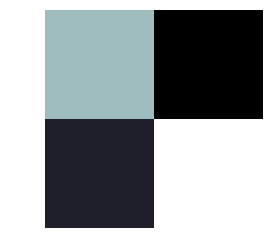

In [108]:
ax = pl.figure().add_subplot(111)
ax.imshow(confusion_matrix(y_test, y_pred), cmap='bone')
ax.axis('off')

print(('[["TP", "FP"], \n ["FN", "TN"]'))
print(confusion_matrix(y_test, y_pred))

True Positive, False Positive in this model have high values. However, as discussed above, it is overfitted. Also, this would  make sense if there is real notion of "positive" and "negative" classes in my data. I selected the ranking into two classes, however this selection is artificial. 